# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

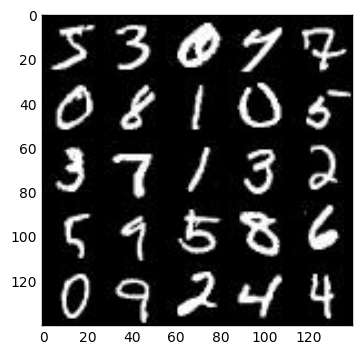

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

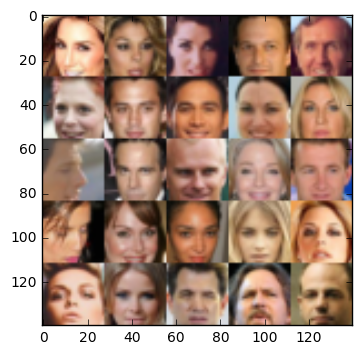

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # Create model inputs
    im_tensor = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    z_tensor = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return im_tensor, z_tensor, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2  # Leaky ReLU hyperparameter
    drop = 0.1  # Drop-out rate
    
    # Set scope to allow re-use
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input is 28 x 28 image
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')  # 14 x 14 x 64 output
        lrelu1 = tf.maximum(alpha * x1, x1)  # Leaky ReLU activation
        
        d1 = tf.layers.dropout(lrelu1, rate=drop)
        
        x2 = tf.layers.conv2d(d1, 128, 5, strides=2, padding='same')  # 7 x 7 x 128 output
        bn1 = tf.layers.batch_normalization(x2, training=True)  # Batch norm
        lrelu2 = tf.maximum(alpha * bn1, bn1)
        
        d2 = tf.layers.dropout(lrelu2, rate=drop)
        
        x3 = tf.layers.conv2d(d2, 256, 5, strides=2, padding='same')  # 4 x 4 x 256 output
        bn2 = tf.layers.batch_normalization(x3, training=True)  # Batch norm
        lrelu3 = tf.maximum(alpha * bn2, bn2)
        
        d3 = tf.layers.dropout(lrelu3, rate=drop)
        
        flat = tf.reshape(d3, (-1, 4*4*256))  # Flatten for use in fully connected layer
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2  # Leaky ReLU hyperparameter
    
    # Set scope to allow re-use
    with tf.variable_scope('generator', reuse = not is_train):
        # Start with fully connected layer with input noise
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape it for use in transpose convolutional layers
        x1 = tf.reshape(x1, (-1, 7, 7, 512))  # 7 x 7 x 512 output
        bn1 = tf.layers.batch_normalization(x1, training=is_train)  # Batch norm
        lrelu1 = tf.maximum(alpha * bn1, bn1)  # Leaky ReLU activation
        
        x2 = tf.layers.conv2d_transpose(lrelu1, 256, 5, strides=2, padding='same')  # 14 x 14 x 256 output
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d_transpose(lrelu2, 128, 5, strides=2, padding='same')  # 28 x 28 x 128 output
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        
        # Output layer - strides=1 with same padding here means 28 x 28 x out_channel_dim output
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # Tanh activation for final putput of generator
        # Normally -1 to 1 after this, so divide by 2 to match -0.5 to 0.5 of real images as mentioned above
        output = tf.tanh(logits)/2
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Get outputs from generator and discriminator
    gen = generator(input_z, out_channel_dim, is_train=True)
    disc_fake_out, disc_fake_logits = discriminator(gen, reuse=False)
    disc_real_out, disc_real_logits = discriminator(input_real, reuse=True)
    
    # Calculate losses for each - real ones smoothed for discriminator to 0.9 instead of 1.0
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_real_logits, labels=tf.ones_like(disc_real_out)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_fake_logits, labels=tf.zeros_like(disc_fake_out)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_fake_logits, labels=tf.ones_like(disc_fake_out)))

    # Discriminator loss is sum of real and fake losses
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and biases from training variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimizizing
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    tf.reset_default_graph()
    
    # Determine number of image channels
    out_channels = 0
    if data_image_mode == 'RGB':
        out_channels = 3
    else:
        out_channels = 1
    
    images_tensor, z_tensor, lr_tensor = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim) 
    d_loss, g_loss = model_loss(images_tensor, z_tensor, out_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr_tensor, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))  # Generate noise to check sample outputs during training

    # Track steps for determining when to show loss & sample outputs
    steps = 0
    
    # Train the Model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1  # Increment steps for each batch

                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={images_tensor: batch_images, z_tensor: batch_z, lr_tensor: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_tensor: batch_z, images_tensor: batch_images, lr_tensor: learning_rate})

                if steps % 10 == 0:
                    # At the end of a given number of steps, get the losses and print them out
                    train_loss_d = d_loss.eval({z_tensor: batch_z, images_tensor: batch_images})
                    train_loss_g = g_loss.eval({z_tensor: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:  # Show samples every 100 steps
                    _ = show_generator_output(sess, 72, z_tensor, out_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4253... Generator Loss: 9.9974
Epoch 1/2... Discriminator Loss: 0.3616... Generator Loss: 9.3358
Epoch 1/2... Discriminator Loss: 1.8590... Generator Loss: 0.7467
Epoch 1/2... Discriminator Loss: 0.4211... Generator Loss: 3.7445
Epoch 1/2... Discriminator Loss: 0.3364... Generator Loss: 6.6563
Epoch 1/2... Discriminator Loss: 0.3372... Generator Loss: 6.4224
Epoch 1/2... Discriminator Loss: 0.3346... Generator Loss: 7.1340
Epoch 1/2... Discriminator Loss: 0.3332... Generator Loss: 7.1986
Epoch 1/2... Discriminator Loss: 0.3303... Generator Loss: 7.5527
Epoch 1/2... Discriminator Loss: 0.3318... Generator Loss: 7.8870


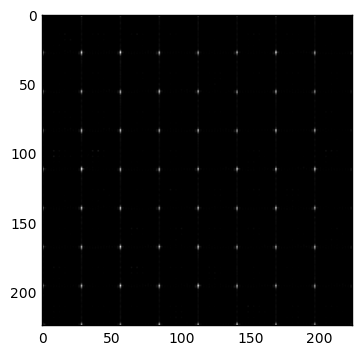

Epoch 1/2... Discriminator Loss: 0.3320... Generator Loss: 7.9017
Epoch 1/2... Discriminator Loss: 0.3310... Generator Loss: 7.5410
Epoch 1/2... Discriminator Loss: 0.3354... Generator Loss: 7.4385
Epoch 1/2... Discriminator Loss: 0.3331... Generator Loss: 8.0534
Epoch 1/2... Discriminator Loss: 0.3303... Generator Loss: 7.6631
Epoch 1/2... Discriminator Loss: 0.3281... Generator Loss: 7.0418
Epoch 1/2... Discriminator Loss: 0.3324... Generator Loss: 7.3587
Epoch 1/2... Discriminator Loss: 0.3340... Generator Loss: 6.2743
Epoch 1/2... Discriminator Loss: 0.3324... Generator Loss: 6.3149
Epoch 1/2... Discriminator Loss: 0.6241... Generator Loss: 2.9805


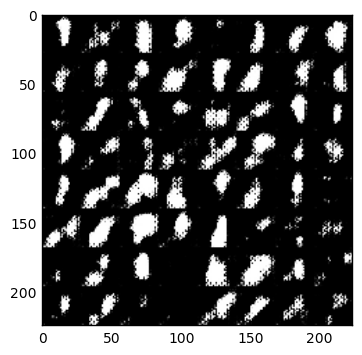

Epoch 1/2... Discriminator Loss: 0.9526... Generator Loss: 1.2328
Epoch 1/2... Discriminator Loss: 1.0807... Generator Loss: 0.8807
Epoch 1/2... Discriminator Loss: 0.9448... Generator Loss: 1.0698
Epoch 1/2... Discriminator Loss: 0.5858... Generator Loss: 2.1497
Epoch 1/2... Discriminator Loss: 0.7576... Generator Loss: 1.6827
Epoch 1/2... Discriminator Loss: 0.6970... Generator Loss: 1.5764
Epoch 1/2... Discriminator Loss: 0.7818... Generator Loss: 1.3806
Epoch 1/2... Discriminator Loss: 1.1501... Generator Loss: 3.9564
Epoch 1/2... Discriminator Loss: 0.7656... Generator Loss: 1.3575
Epoch 1/2... Discriminator Loss: 0.5645... Generator Loss: 2.2362


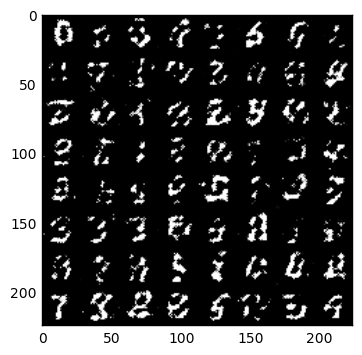

Epoch 1/2... Discriminator Loss: 0.6604... Generator Loss: 1.8223
Epoch 1/2... Discriminator Loss: 0.5937... Generator Loss: 1.9131
Epoch 1/2... Discriminator Loss: 1.3894... Generator Loss: 5.2987
Epoch 1/2... Discriminator Loss: 0.6374... Generator Loss: 1.6326
Epoch 1/2... Discriminator Loss: 0.4241... Generator Loss: 2.8935
Epoch 1/2... Discriminator Loss: 1.7225... Generator Loss: 0.4793
Epoch 1/2... Discriminator Loss: 1.0553... Generator Loss: 6.0098
Epoch 1/2... Discriminator Loss: 0.6220... Generator Loss: 4.3600
Epoch 1/2... Discriminator Loss: 0.5833... Generator Loss: 2.7547
Epoch 1/2... Discriminator Loss: 0.9737... Generator Loss: 1.5009


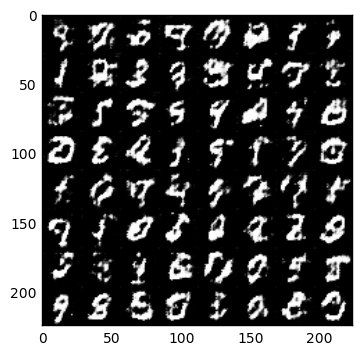

Epoch 1/2... Discriminator Loss: 1.1787... Generator Loss: 2.0734
Epoch 1/2... Discriminator Loss: 1.4396... Generator Loss: 0.5917
Epoch 1/2... Discriminator Loss: 1.1581... Generator Loss: 1.7255
Epoch 1/2... Discriminator Loss: 1.0028... Generator Loss: 1.1479
Epoch 1/2... Discriminator Loss: 1.2711... Generator Loss: 1.1735
Epoch 1/2... Discriminator Loss: 1.2589... Generator Loss: 1.1428
Epoch 2/2... Discriminator Loss: 1.2040... Generator Loss: 1.2016
Epoch 2/2... Discriminator Loss: 1.1170... Generator Loss: 0.9413
Epoch 2/2... Discriminator Loss: 1.0963... Generator Loss: 0.9845
Epoch 2/2... Discriminator Loss: 1.2556... Generator Loss: 0.7125


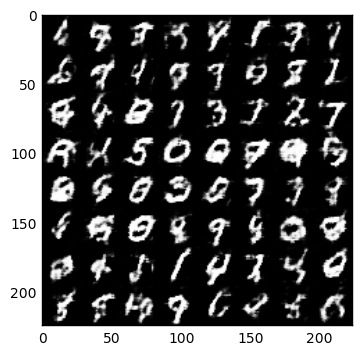

Epoch 2/2... Discriminator Loss: 1.0228... Generator Loss: 1.2066
Epoch 2/2... Discriminator Loss: 1.1304... Generator Loss: 1.0271
Epoch 2/2... Discriminator Loss: 1.0948... Generator Loss: 0.8913
Epoch 2/2... Discriminator Loss: 1.1236... Generator Loss: 0.8891
Epoch 2/2... Discriminator Loss: 1.3164... Generator Loss: 2.2670
Epoch 2/2... Discriminator Loss: 0.9848... Generator Loss: 1.2304
Epoch 2/2... Discriminator Loss: 0.9986... Generator Loss: 1.5455
Epoch 2/2... Discriminator Loss: 1.0535... Generator Loss: 1.7157
Epoch 2/2... Discriminator Loss: 1.0892... Generator Loss: 0.9793
Epoch 2/2... Discriminator Loss: 0.9720... Generator Loss: 1.0741


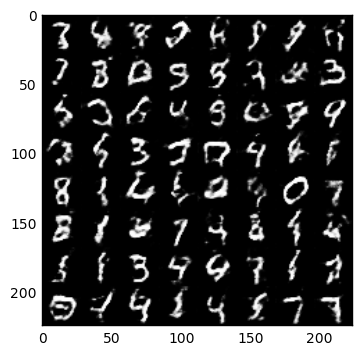

Epoch 2/2... Discriminator Loss: 1.1698... Generator Loss: 0.6735
Epoch 2/2... Discriminator Loss: 1.0036... Generator Loss: 1.1797
Epoch 2/2... Discriminator Loss: 1.0669... Generator Loss: 1.1984
Epoch 2/2... Discriminator Loss: 1.3990... Generator Loss: 0.5405
Epoch 2/2... Discriminator Loss: 1.0498... Generator Loss: 0.9183
Epoch 2/2... Discriminator Loss: 1.1222... Generator Loss: 0.8086
Epoch 2/2... Discriminator Loss: 0.9348... Generator Loss: 1.9653
Epoch 2/2... Discriminator Loss: 1.3472... Generator Loss: 2.3019
Epoch 2/2... Discriminator Loss: 0.8563... Generator Loss: 1.1932
Epoch 2/2... Discriminator Loss: 0.9784... Generator Loss: 1.2923


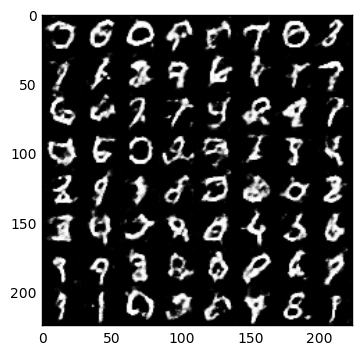

Epoch 2/2... Discriminator Loss: 0.9955... Generator Loss: 0.8952
Epoch 2/2... Discriminator Loss: 0.9208... Generator Loss: 1.5236
Epoch 2/2... Discriminator Loss: 0.8592... Generator Loss: 1.3274
Epoch 2/2... Discriminator Loss: 1.0449... Generator Loss: 0.8368
Epoch 2/2... Discriminator Loss: 1.0322... Generator Loss: 0.9200
Epoch 2/2... Discriminator Loss: 0.9566... Generator Loss: 1.0131
Epoch 2/2... Discriminator Loss: 1.1107... Generator Loss: 0.7791
Epoch 2/2... Discriminator Loss: 0.9466... Generator Loss: 1.2384
Epoch 2/2... Discriminator Loss: 0.9412... Generator Loss: 0.9716
Epoch 2/2... Discriminator Loss: 1.0060... Generator Loss: 1.6001


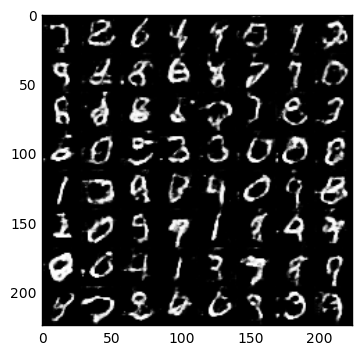

Epoch 2/2... Discriminator Loss: 1.1430... Generator Loss: 0.7806
Epoch 2/2... Discriminator Loss: 1.0704... Generator Loss: 0.8844
Epoch 2/2... Discriminator Loss: 0.9603... Generator Loss: 1.9774
Epoch 2/2... Discriminator Loss: 0.8806... Generator Loss: 1.0995
Epoch 2/2... Discriminator Loss: 0.9221... Generator Loss: 0.9821
Epoch 2/2... Discriminator Loss: 0.8749... Generator Loss: 1.0554
Epoch 2/2... Discriminator Loss: 1.0328... Generator Loss: 1.5373
Epoch 2/2... Discriminator Loss: 1.0093... Generator Loss: 2.3914
Epoch 2/2... Discriminator Loss: 0.9134... Generator Loss: 2.4791
Epoch 2/2... Discriminator Loss: 0.9338... Generator Loss: 1.4093


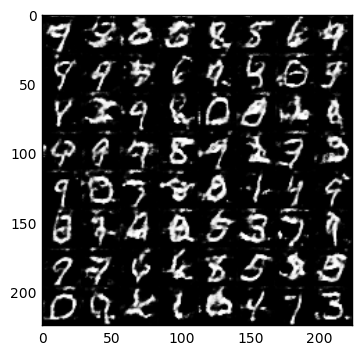

Epoch 2/2... Discriminator Loss: 1.2646... Generator Loss: 0.6248
Epoch 2/2... Discriminator Loss: 0.9364... Generator Loss: 1.1364
Epoch 2/2... Discriminator Loss: 1.1603... Generator Loss: 0.7877


IndexError: list index out of range

In [22]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4454... Generator Loss: 5.1700
Epoch 1/1... Discriminator Loss: 0.4800... Generator Loss: 4.4837
Epoch 1/1... Discriminator Loss: 0.7943... Generator Loss: 1.6738
Epoch 1/1... Discriminator Loss: 2.0927... Generator Loss: 0.3407
Epoch 1/1... Discriminator Loss: 0.6927... Generator Loss: 3.5966
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 9.2565
Epoch 1/1... Discriminator Loss: 0.6726... Generator Loss: 5.8202
Epoch 1/1... Discriminator Loss: 0.3698... Generator Loss: 4.9209
Epoch 1/1... Discriminator Loss: 0.3573... Generator Loss: 6.5110
Epoch 1/1... Discriminator Loss: 0.3513... Generator Loss: 6.2984


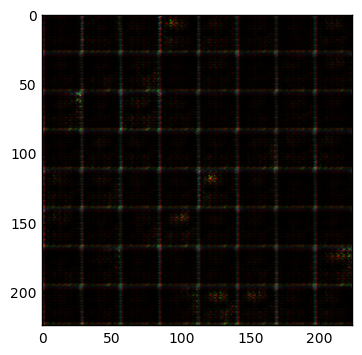

Epoch 1/1... Discriminator Loss: 0.3842... Generator Loss: 3.2672
Epoch 1/1... Discriminator Loss: 0.3726... Generator Loss: 5.3411
Epoch 1/1... Discriminator Loss: 0.4064... Generator Loss: 3.4474
Epoch 1/1... Discriminator Loss: 3.4872... Generator Loss: 10.5306
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 0.5027... Generator Loss: 3.0115
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 4.2849
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 0.7703... Generator Loss: 1.9145
Epoch 1/1... Discriminator Loss: 0.6595... Generator Loss: 1.7328


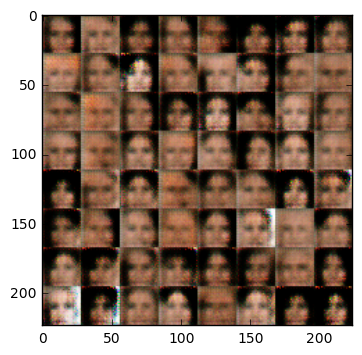

Epoch 1/1... Discriminator Loss: 1.8705... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 1.0646
Epoch 1/1... Discriminator Loss: 0.8323... Generator Loss: 2.1810
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 1.7735
Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.9092
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 1.3943
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 1.1102
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 0.8141... Generator Loss: 1.8270
Epoch 1/1... Discriminator Loss: 1.7175... Generator Loss: 2.2300


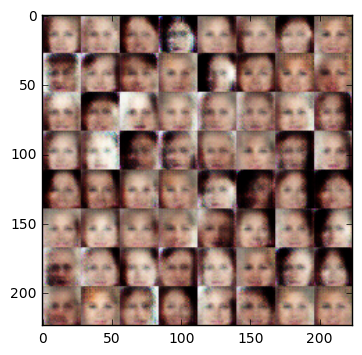

Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 1.6221
Epoch 1/1... Discriminator Loss: 1.6152... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 1.1516
Epoch 1/1... Discriminator Loss: 1.5392... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.9911
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 1.0486
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.8603


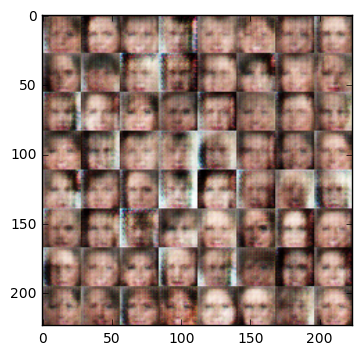

Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.5690... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7544


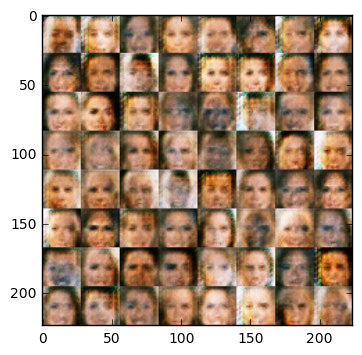

Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.9815
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.9590
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.7763


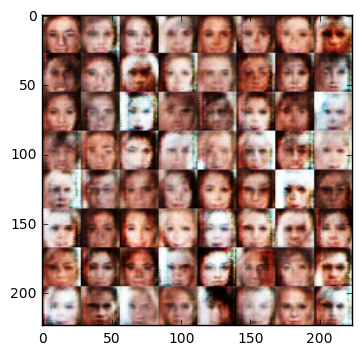

Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.8404
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.7577


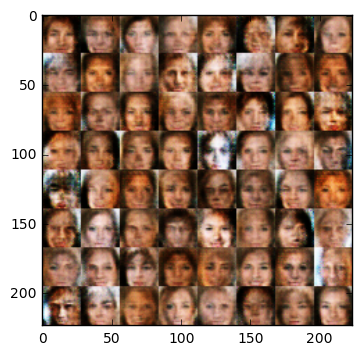

Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.9432
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 1.0184
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.9559
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.8095


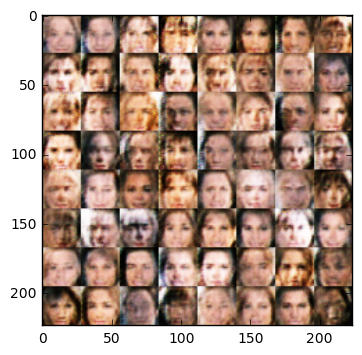

Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 1.4129
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.8114


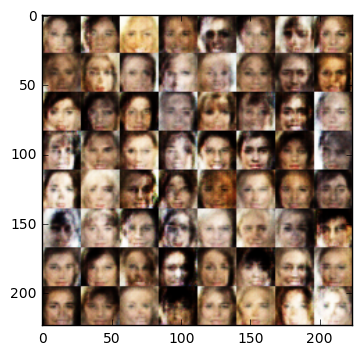

Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 1.0203
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.9376
Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.9075
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.8547


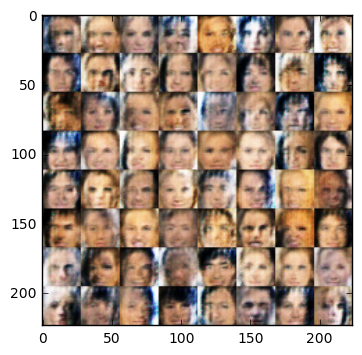

Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 1.0430
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 0.8792


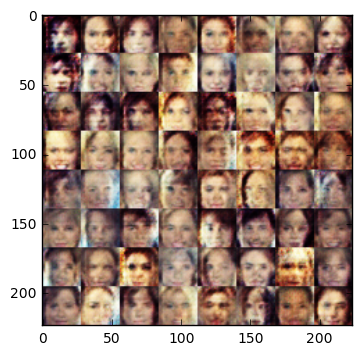

Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 0.9457
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 1.0075
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.8996
Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.9748


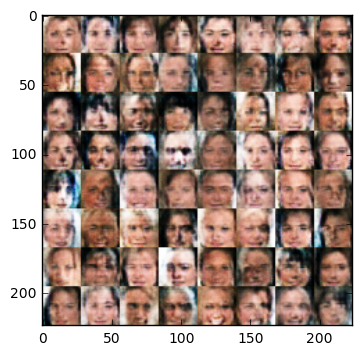

Epoch 1/1... Discriminator Loss: 1.5980... Generator Loss: 1.5512
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 1.1037
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 1.0165
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.5448... Generator Loss: 0.5529
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 1.2755
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.8484


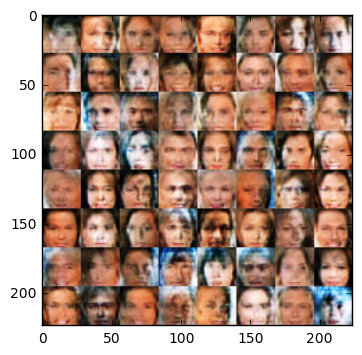

Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 1.3118
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.7898


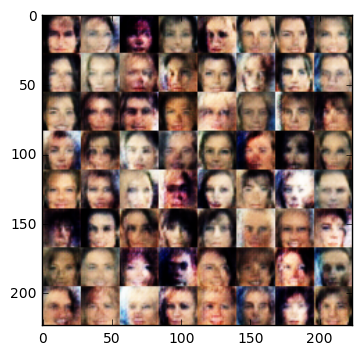

Epoch 1/1... Discriminator Loss: 2.0160... Generator Loss: 3.0074
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.6597
Epoch 1/1... Discriminator Loss: 0.8222... Generator Loss: 1.8704
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.5646
Epoch 1/1... Discriminator Loss: 0.7601... Generator Loss: 1.2096
Epoch 1/1... Discriminator Loss: 0.5807... Generator Loss: 1.6772
Epoch 1/1... Discriminator Loss: 0.5026... Generator Loss: 3.0054
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 0.7335... Generator Loss: 1.8846
Epoch 1/1... Discriminator Loss: 0.3794... Generator Loss: 3.8269


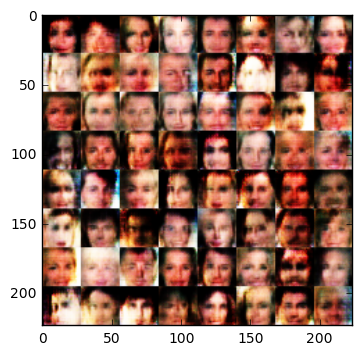

Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 6.1640
Epoch 1/1... Discriminator Loss: 0.6855... Generator Loss: 1.4957
Epoch 1/1... Discriminator Loss: 0.7487... Generator Loss: 3.7775
Epoch 1/1... Discriminator Loss: 0.3432... Generator Loss: 6.5182
Epoch 1/1... Discriminator Loss: 0.4341... Generator Loss: 2.4973
Epoch 1/1... Discriminator Loss: 1.7346... Generator Loss: 0.3294
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 1.0575
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 1.0352


IndexError: list index out of range

In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.